# Using PyMC3 samplers on pymc_tfp models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc_tfp as pm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Create simple pymc_tfp model
@pm.model(auto_name=True)
def t_test():
    mu = pm.Normal(0, 1)

model = t_test.configure()

model._forward_context.vars
func = model.make_log_prob_function()

In [4]:
# Create function to evaluate logp and dlogp over array of inputs
@tf.function
def logp_array(array):
    #mu = array[0]
    with tf.GradientTape() as tape:
        tape.watch(array)
        logp = func(array)
    grad = tape.gradient(logp, array)
    
    return logp, grad

In [5]:
# As the above function expects TF inputs and outputs, wrap it as PyMC3's samplers want numpy
def logp_wrapper(array):
    logp, grad = logp_array(tf.convert_to_tensor(array))
    return logp.numpy(), grad.numpy()

In [6]:
from pymc_tfp.hmc import HamiltonianMC

In [7]:
size = 1
n_samples = 500

In [8]:
tf.random.set_seed(123)
np.random.seed(123)
hmc = HamiltonianMC(logp_dlogp_func=logp_wrapper, size=size, adapt_step_size=False)
curr = np.ones(size, dtype='float32') * .05
posterior_samples = []
stats = []

In [9]:
# %%time  # NB: uncommenting cell magic %%time will prevent variable from escaping local cell scope

for i in range(n_samples):
    curr, stat = hmc.step(curr)
    posterior_samples.append(curr)
    stats.append(stat)
    if i % 10 == 0:
        print(i)
        print(hmc.step_size)
    
trace = np.array(posterior_samples)

0
0.25
10
2.4338525715809687
20
0.8835782022550135
30
2.1327029448576513
40
0.6636198591746387
50
0.7703623177523709
60
1.8082085533140866
70
2.016802124717785
80
0.6217015104339201
90
1.207940992513313
100
1.3240099603905968
110
1.346048853571611
120
1.4427577775129503
130
0.8565491707334623
140
0.9624691955794613
150
2.4720718932582906
160
1.5805445755750056
170
2.1380879550318665
180
1.420551901927288
190
1.772666882095104
200
1.4909935183397898
210
0.9564664645510188
220
1.0094633430712847
230
0.9415898885107509
240
0.9789093380505235
250
1.006542783540078
260
0.9103849564026153
270
1.55622156748228
280
3.088911988511081
290
1.4383936543460296
300
1.1121804701838218
310
1.424086887611018
320
2.20499869286127
330
1.519518011454376
340
1.3419589165701242
350
1.9586890867688238
360
1.6645487485996129
370
0.9915868782338413
380
1.0335682127160022
390
2.580381765734188
400
0.8539483762542414
410
1.6204564049940595
420
1.7482972684183884
430
1.0932177164504921
440
1.1029667164138135
450


Compare with `PyMC3`

In [10]:
import pymc3 as pm3

W0414 17:16:25.698212 140348081661760 configdefaults.py:1458] install mkl with `conda install mkl-service`: No module named 'mkl'


In [11]:
with pm3.Model() as model3:
    pm3.Normal('x', 0, 1)

In [12]:
np.random.seed(123)
with model3:
    hmc3 = pm3.HamiltonianMC(adapt_step_size=True)
    
point = {'x': np.array(.05)}
trace3 = []

In [13]:
%%time

for i in range(n_samples):
    point, _ = hmc3.step(point)
    trace3.append(point['x'])
    if i % 10 == 0:
        print(i)
        print(hmc3.step_size)

0
0.25
10
2.4338363922634105
20
0.8835295148661158
30
2.132369805866789
40
0.6638539397446028
50
0.7700032438774976
60
1.8083500351406778
70
2.01549699366806
80
0.620051066822726
90
1.2394151791390735
100
1.326608190951551
110
1.3458859508747132
120
1.4535020800208394
130
0.8470025039761001
140
0.9616054472149861
150
2.4700446424546842
160
1.579485048302955
170
2.126076524692899
180
1.4263912419505649
190
1.778245696911592
200
1.4859097351789183
210
0.9546259420166145
220
1.0072250233799054
230
0.9409202999644469
240
0.9783484856905771
250
1.0058739854796497
260
0.9099078292987351
270
1.5554539165456562
280
3.088081197599752
290
1.4375634311726395
300
1.1117815200764143
310
1.4225316718871723
320
2.2024230776071763
330
1.5205261622590753
340
1.3428281946994207
350
1.9597477496000024
360
1.665457343355618
370
0.9921134467269729
380
1.034038006686061
390
2.5815148520987616
400
0.8542902108760975
410
1.621225265014004
420
1.749029446162765
430
1.0936219616260738
440
1.103351819226634
450


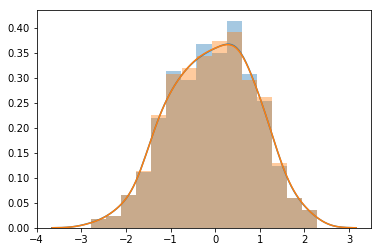

In [14]:
import seaborn as sns
sns.distplot(trace)
sns.distplot(trace3)

There still seems to be a problem here where in the pymc_tfp implementation, the step_size keeps getting smaller and smaller, causing the sampler to take very long. Haven't figured it out yet.

In [15]:
hmc.step_size

1.7264840418426366

In [16]:
hmc3.step_size

1.7268868356485505

In [17]:
hmc.potential._stds

array([0.97779363])

In [18]:
hmc3.potential._stds

array([0.97756585])